In [3]:
# import for rosbag
%matplotlib inline
import os
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from rosbags.typesys import Stores, get_typestore

In [4]:
# function to get pose from bag file
def get_trajs(data_dir, bag_file, topic):

    """
    Args:
        data_dir (str): directory where bag file is stored
        bag_file (str): name of bag file
        topic (str): topic name to extract pose data from

    Returns:
        poses (np.array): array of poses
        timestamps (np.array): array of timestamps
    """
    
    # lists to store data
    poses = []
    timestamps = []
    
    # create reader instance and open for reading
    with Reader(os.path.join(data_dir, bag_file)) as reader:

        # topic and msgtype information is available on .connections list
        for connection in reader.connections:
            print(connection.topic, connection.msgtype)

        # iterate over messages
        for connection, _, rawdata in reader.messages():
            
            if connection.topic == topic:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                poses.append([msg.pose.position.x, msg.pose.position.y, msg.pose.position.z, msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w])
                timestamps.append(msg.header.stamp.sec + msg.header.stamp.nanosec * 1e-9)
        
    # convert to numpy array
    poses = np.array(poses)
    timestamps = np.array(timestamps)

    return poses, timestamps

In [5]:
# apply 210 degree rotation to the dlio pose (to match the vicon object frame and livox frame)
pose_dlio.T_postmultiply = transform.T2d_2_T3d(transform.xytheta_to_transform(0, 0, np.deg2rad(210)))

# get the initial poses
initial_vicon_pose = pose_vicon.pose(pose_vicon.t0)
initial_dlio_pose = pose_dlio.pose(pose_vicon.t0)

# calculate the transformation between the two poses
T_w_odom = initial_vicon_pose @ np.linalg.inv(initial_dlio_pose)

# apply the transformation to the dlio pose
pose_dlio.T_premultiply = T_w_odom

<Axes: xlabel='y', ylabel='z'>

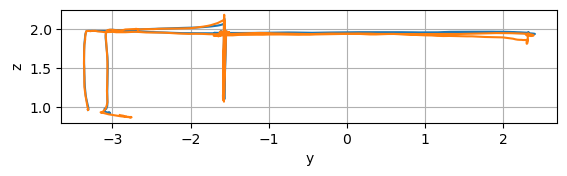

In [11]:
# plot
pose_vicon.plot2d(pose=False, axes="yz")
pose_dlio.plot2d(pose=False, axes="yz")

<Axes: xlabel='x', ylabel='y'>

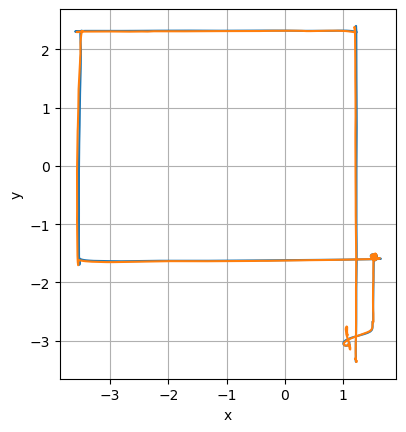

In [12]:
# plot
pose_vicon.plot2d(pose=False, axes="xy")
pose_dlio.plot2d(pose=False, axes="xy")

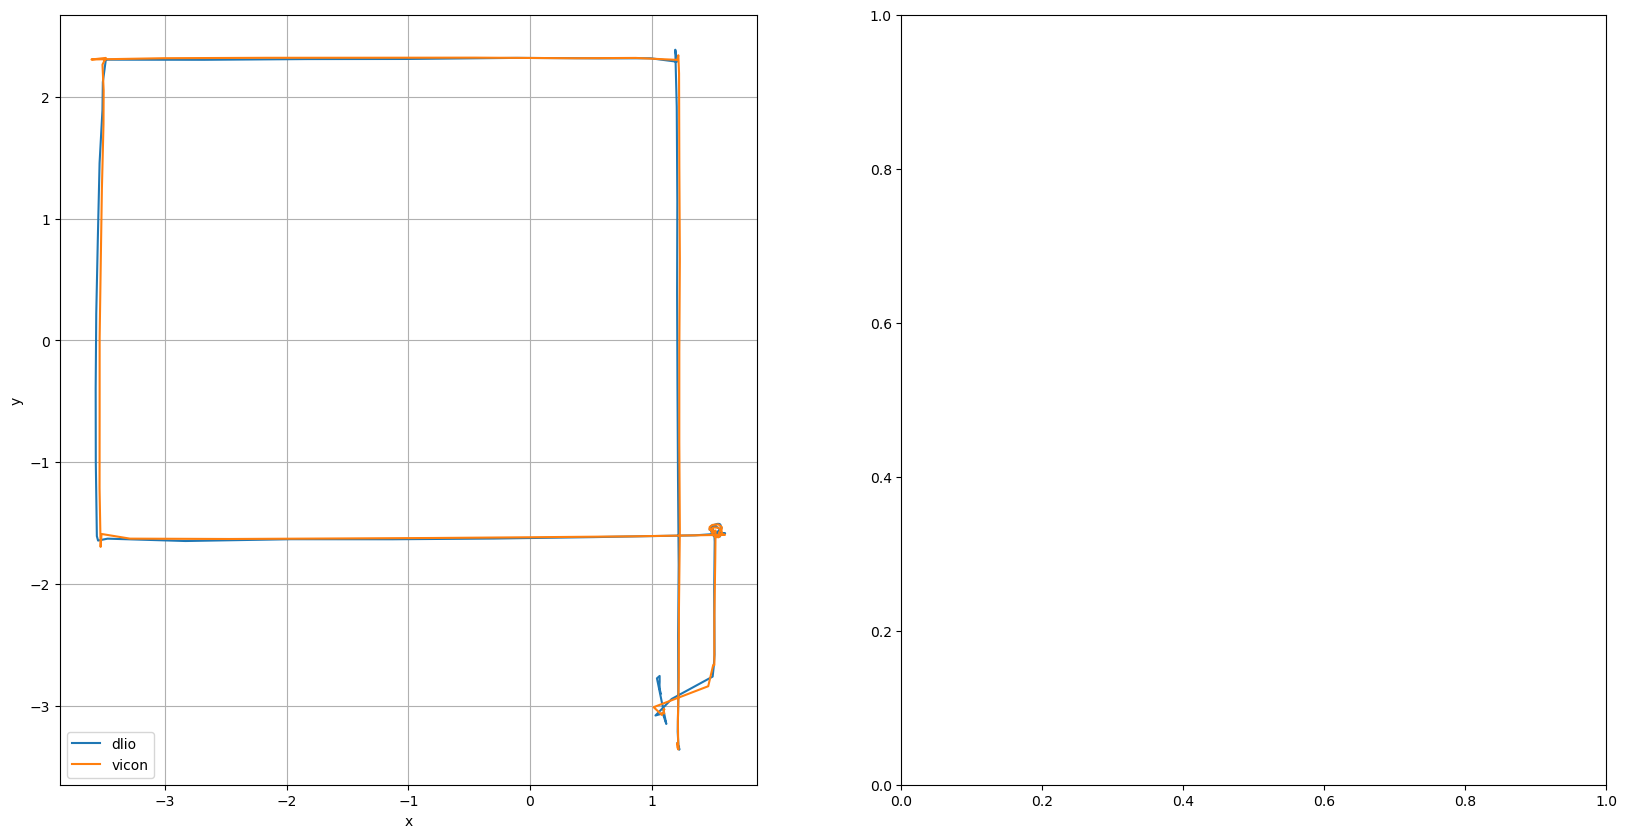

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
dt = 40.0
pose_dlio.plot2d(ax=ax[0], label="dlio", pose=False, t=pose_dlio.times[::80])
pose_vicon.plot2d(ax=ax[0], label="vicon", pose=False, t=pose_vicon.times[::80])
ax[0].legend()
plt.show()